In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import matplotlib.pyplot as plt
#import torch
from modelling_fctns import double_logistic, normalized_difference
import data_cleaning
import LSP

import libtlda.tca

import adapt.feature_based

import cv2
from PIL import Image

import scipy.signal
from scipy.interpolate import make_smoothing_spline
#

In [18]:
def cross_percentile_date(smoothed_series, percentile):
    # Calculate the 90th percentile
    percentile_value = np.percentile(smoothed_series, percentile)
    # Identify when the time series crosses the 90th percentile
    crosses_percentile = (smoothed_series > percentile_value).astype(int).diff().fillna(0).astype(bool)

    # Extract the dates when the crossing occurs
    crossing_dates = smoothed_series.index[crosses_percentile]
    return(crossing_dates)

def double_logistic_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    params, _ = scipy.optimize.curve_fit(modelling_fctns.double_logistic, Times/365, values, maxfev = 10000)
    smoothed_series = pd.Series(modelling_fctns.double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def spline_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    spl = make_smoothing_spline(Times/365, values, lam = 0.00001)
    smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
    #print(Tighter_times/365, smoothed_series.idxmax(), smoothed_series)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    print(spl(Tighter_times[np.int64(smoothed_series.idxmax()*365)]/365), max_green, spl(Tighter_times/365).max())
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def savgol_LSP(values, Times, first_date, window_length=50, polyorder=2):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)[5:-5]
    smoothed_derivs = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder,  deriv=1), index=Times)[5:-5]
    mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
    maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
    minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
    maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0], 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0], 'D')
    if len(cross_percentile_date(smoothed_series, 75)) < 2:
        percentile_75a = first_date - pd.Timedelta(9999, 'D')
        percentile_75b = first_date - pd.Timedelta(9999, 'D')
    else:
        percentile_75a = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 75)[-2], 'D')
        percentile_75b = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 75)[-1], 'D')
    return mingrad, maxgrad, minday, maxday, percentile_75a, percentile_75b

def initialize_LSP_frame(LSP_method):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'percentile_10', 'percentile_50', 'percentile_90', 'percentile_10_2nd', 'max_green'])
    elif LSP_method == 'savgol':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile'])
    return results

def append_LSP_frame(results, LSPs):
    results.loc[-1] = LSPs
    results.index = results.index + 1
    results = results.sort_index()
    return results

def calculate_append_LSP_frame(results, values, Times, first_date, LSP_method, year, station):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        if LSP_method == 'double_logistic':
            LSPs = double_logistic_LSP(values, Times, first_date)
        else:
            LSPs = spline_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol':
        LSPs = savgol_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    return results

def LSP_at_stations(ds, start_year, end_year, LSP_method = 'double_logistic', interp_method = 'linear'):
    results = initialize_LSP_frame(LSP_method)
    print(results)
    for year in range(start_year, end_year + 1):
        print(f'Year: {year}')
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[ds['Stations_Id'] == station]
            ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])
            if len(ds_station_year) > 7:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            else:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations so ignored')
                continue
            try:
                if interp_method == 'linear':
                    ds_interpolated = data_cleaning.resample_linear(ds_station_year)
                elif interp_method == 'MVI':
                    ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=4) #data_cleaning.
            except:
                print('Couldn\'t interpolate')
                continue
            ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
            Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
            NDVIs = ds_interpolated['NDVI'].values
            first_date = ds_interpolated['time'].min()
            NDVIs = ds_interpolated['NDVI'].values
            #try:
            results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station)
            #except:
                #print(f'Couldn\'t compute LSP for station {station} in year {year}')
                #continue
    return results, ds_interpolated

In [19]:
for first_in_file in np.arange(0, 825, 25):
    print(f'File {first_in_file}')
    try:
        ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{first_in_file}.csv')
    except:
        continue
    ds = ds.where(ds['NDVI'] != -9999).dropna()
    ds = ds.where(ds['reducer'] == 'median').dropna()
    ds['date'] = pd.to_datetime(ds['date'])
    ds['year'] = ds['date'].dt.year
    ds = data_cleaning.add_EOS_to_df(ds)
    ds = data_cleaning.add_SOS_to_df(ds)
    #ds['NDVI'] = normalized_difference(ds['median B4'], ds['median B8'])
    if first_in_file == 0:
        LSP_times, ds_interpolted = LSP_at_stations(ds, 2017, 2024, LSP_method='savgol')
    else:
        LSP_times = pd.concat([LSP_times, LSP_at_stations(ds, 2017, 2024, LSP_method='savgol')[0]], axis=0)

File 0
Empty DataFrame
Columns: [year, Stations_Id, mingrad, maxgrad, minday, maxday, second last 75 percentile, last 75 percentile]
Index: []
Year: 2017
Station 7521.0 in 2017 has 6 observations so ignored
Station 7532.0 in 2017 has 9 observations
Station 7564.0 in 2017 has 8 observations
Station 7592.0 in 2017 has 19 observations
Station 7608.0 in 2017 has 10 observations
Station 7616.0 in 2017 has 8 observations
Station 7623.0 in 2017 has 15 observations
Station 7624.0 in 2017 has 10 observations
Station 7642.0 in 2017 has 12 observations
Station 7646.0 in 2017 has 12 observations
Station 7650.0 in 2017 has 28 observations
Station 7662.0 in 2017 has 8 observations
Station 7665.0 in 2017 has 7 observations so ignored
Station 7671.0 in 2017 has 9 observations
Station 7676.0 in 2017 has 8 observations
Station 7682.0 in 2017 has 3 observations so ignored
Station 7697.0 in 2017 has 12 observations
Station 7700.0 in 2017 has 8 observations
Station 7711.0 in 2017 has 8 observations
Station

In [13]:
LSP_times

,year,Stations_Id,mingrad,maxgrad,minday,maxday,second last 75 percentile,last 75 percentile
0,2024,7743.0,2024-05-06,2024-07-18,2024-06-04,2024-10-01,2024-08-31,2024-10-13
1,2024,7737.0,2024-06-08,2024-08-24,2024-07-25,2024-05-06,2024-10-01,2024-10-19
2,2024,7736.0,2024-10-02,2024-07-04,2024-10-28,2024-09-13,2024-09-09,2024-09-17
3,2024,7734.0,2024-10-28,2024-07-14,2024-06-14,2024-08-11,2024-09-26,2024-10-02
4,2024,7730.0,2024-07-28,2024-05-06,2024-10-08,2024-06-17,2024-05-30,2024-07-13
...,...,...,...,...,...,...,...,...
195,2017,8293.0,2017-05-17,2017-04-08,2017-06-03,2017-04-29,2017-07-05,2017-10-12
196,2017,8285.0,2017-08-06,2017-06-17,2017-05-12,2017-07-16,2017-06-30,2017-08-02
197,2017,8282.0,2017-10-02,2017-05-02,2017-11-08,2017-05-26,2017-07-13,2017-07-25
198,2017,8279.0,2017-04-25,2017-06-14,2017-05-08,2017-07-22,2017-08-27,2017-11-02


In [12]:
ds_interpolted

,time,Unnamed: 0,B4,B5,B6,B7,B8,NDVI,reducer,lat,lon,Stations_Id,year,EOS,SOS
0,2024-05-01,2047.000000,463.0,949.000000,2499.000000,2919.000000,2732.000000,0.710172,median,54.35,9.2167,7743.0,2024.0,298.0,103.0
1,2024-05-02,2047.500000,430.5,1017.500000,2729.500000,3238.500000,3260.000000,0.760007,NaN,54.35,9.2167,7743.0,2024.0,298.0,103.0
2,2024-05-03,2048.000000,398.0,1086.000000,2960.000000,3558.000000,3788.000000,0.809842,median,54.35,9.2167,7743.0,2024.0,298.0,103.0
3,2024-05-04,2048.333333,371.0,1047.666667,2980.333333,3618.666667,3824.000000,0.823066,NaN,54.35,9.2167,7743.0,2024.0,298.0,103.0
4,2024-05-05,2048.666667,344.0,1009.333333,3000.666667,3679.333333,3860.000000,0.836290,NaN,54.35,9.2167,7743.0,2024.0,298.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2024-10-29,2119.600000,625.2,977.600000,1433.600000,1650.800000,2095.200000,0.538833,NaN,54.35,9.2167,7743.0,2024.0,298.0,103.0
182,2024-10-30,2120.000000,550.0,864.000000,1251.000000,1424.000000,1820.000000,0.535865,median,54.35,9.2167,7743.0,2024.0,298.0,103.0
183,2024-10-31,2120.333333,537.0,912.333333,1333.000000,1625.333333,2032.666667,0.575835,NaN,54.35,9.2167,7743.0,2024.0,298.0,103.0
184,2024-11-01,2120.666667,524.0,960.666667,1415.000000,1826.666667,2245.333333,0.615806,NaN,54.35,9.2167,7743.0,2024.0,298.0,103.0


In [10]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds = data_cleaning.add_SOS_to_df(ds)
ds = data_cleaning.add_EOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated = data_cleaning.map_max_value_int(ds, window_size=8)
array_input = data_cleaning.make_df_samples(max_value_interpolated, sample_number = 1000, m_window_size = 5)
sampled_locs_input = data_cleaning.make_tensor_from_timeseries(max_value_interpolated, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

KeyError: 'date'

In [ ]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2 = data_cleaning.add_SOS_to_df(ds2)
ds2 = data_cleaning.add_EOS_to_df(ds2)
ds2['NDVI'] = normalized_difference(ds2['median sur_refl_b02'], ds2['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
array_input2 = data_cleaning.make_df_samples(max_value_interpolated2, sample_number = 1000, m_window_size = 5)
sampled_locs_input2 = data_cleaning.make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [ ]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
LSP_times = LSP.LSP_at_stations(ds, 2020, 2021, LSP_method='savgol', interp_method='linear')

In [ ]:
station = ds['Stations_Id'].unique()[0]
year = 2020
ds_station = ds.loc[ds['Stations_Id'] == station]
ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])

In [ ]:
LSP_times.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times.csv')

In [27]:
def plot_many_NDVI_curves(ds, year, font_size = 15, interp_method = 'linear', curve = 'double_logistic', window_length=50, polyorder=2): #shift = 0, 
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    location_index = 0
    #shift = 0
    failures = 0
    while location_index - failures < 10: #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().dropna().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
        try:
            if interp_method == 'linear':
                ds_interpolated = data_cleaning.resample_linear(ds_year)
            elif interp_method == 'MVI':
                ds_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=4) #data_cleaning.
        except:
            print('Couldn\'t interpolate')
            failures += 1
            location_index += 1
            continue
        print(location_index, latlon['lat'], latlon['lon'])
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        #print(Times.shape, Tighter_times.shape)
        NDVIs = ds_interpolated['NDVI'].values
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        try:
            if curve == 'spline':
                spl = make_smoothing_spline(Times/365, NDVIs, lam = 0.00001)
                smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
            elif curve == 'double_logistic':
                params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
                smoothed_series = pd.Series(double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
            #axs[location_index - failures].plot(ds_interpolated['time'].min() + pd.to_timedelta((smoothed_series.index)*365, 'D'), smoothed_series, label = 'Fit')
        except:
            print('Couldn\'t fit')
        if interp_method == 'linear':
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
            #smoothed_derivs = scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder,  deriv=1)
            #axs[location_index - failures].plot(first_date + Times.astype('timedelta64[D]'), smoothed_derivs, label = 'NDVI, S-G smooth', color = 'black')
        else:
            axs[location_index - failures].scatter(first_date + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder, deriv = 0), label = 'Data')
            axs[location_index - failures].scatter(first_date + Times.astype('timedelta64[D]'), NDVIs, label = 'Data', color = 'red')
        
        savgol_dates = savgol_LSP(NDVIs, Times, first_date, window_length=window_length)
        #smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=window_length, polyorder=polyorder, deriv=0), index=Times)
        smoothed_derivs = pd.Series(scipy.signal.savgol_filter(NDVIs, window_length=window_length, polyorder=polyorder,  deriv=1), index=Times)
        mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
        maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
        #minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
        #maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
        #axs[location_index - failures].axvline(x = savgol_dates[3], color='r', linestyle=':', label = 'maxday')
        #axs[location_index - failures].axvline(x = savgol_dates[2], color='r', linestyle='--', label = 'minday')
        axs[location_index - failures].axvline(x = savgol_dates[1], color='r', label = 'maxgrad')
        axs[location_index - failures].axvline(x = savgol_dates[0], color='b', linestyle='--', label = 'mingrad')
        axs[location_index - failures].axvline(x = savgol_dates[5], color='r', linestyle=':', label = 'last 90th percentile hit')
        axs[location_index - failures].axvline(x = savgol_dates[4], color='r', linestyle='--', label = 'first 90th percentile hit')
        emergence_date = pd.to_datetime(ds_year['emergence date'].iloc[0])
        try:
            axs[location_index - failures].axvline(x = emergence_date, color='k', label = 'emergence date')
        except:
            print('No emergence date')
        calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
        axs[location_index - failures].axvline(x = calendar_SOS, color='k', linestyle='--', label = 'SOS from worldcereal')
        try:
            observed_time_emergence_to_yellow_ripeness = pd.to_datetime(ds_year['emergence date'].iloc[0]) + pd.Timedelta(ds_year['observed time emergence to yellow ripeness'].iloc[0], 'D')
            axs[location_index - failures].axvline(x = observed_time_emergence_to_yellow_ripeness, color='k', linestyle=':', label = 'observed ripeness')
            axs[location_index - failures].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
        except:
            print('no maturity data')

        axs[location_index - failures].set_xlabel('Day of Year', fontsize = font_size)
        axs[location_index - failures].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[location_index - failures].tick_params(labelrotation=45)
        location_index += 1
    fig.suptitle('Year of MODIS NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
    print(f'There were {failures} failures')
        

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Te

0 54.4333 9.8167
1 54.4 8.7667
2 54.7167 9.95
No emergence date
no maturity data
3 53.4833 10.6333
no maturity data
4 53.5 10.4833
no maturity data
5 54.6167 8.9667


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Te

6 54.6667 9.1333
7 54.5167 8.65
no maturity data
8 54.2333 11.0833
9 54.25 10.8333
no maturity data


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_15400\3053189578.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


104.0
297.0
There were 0 failures


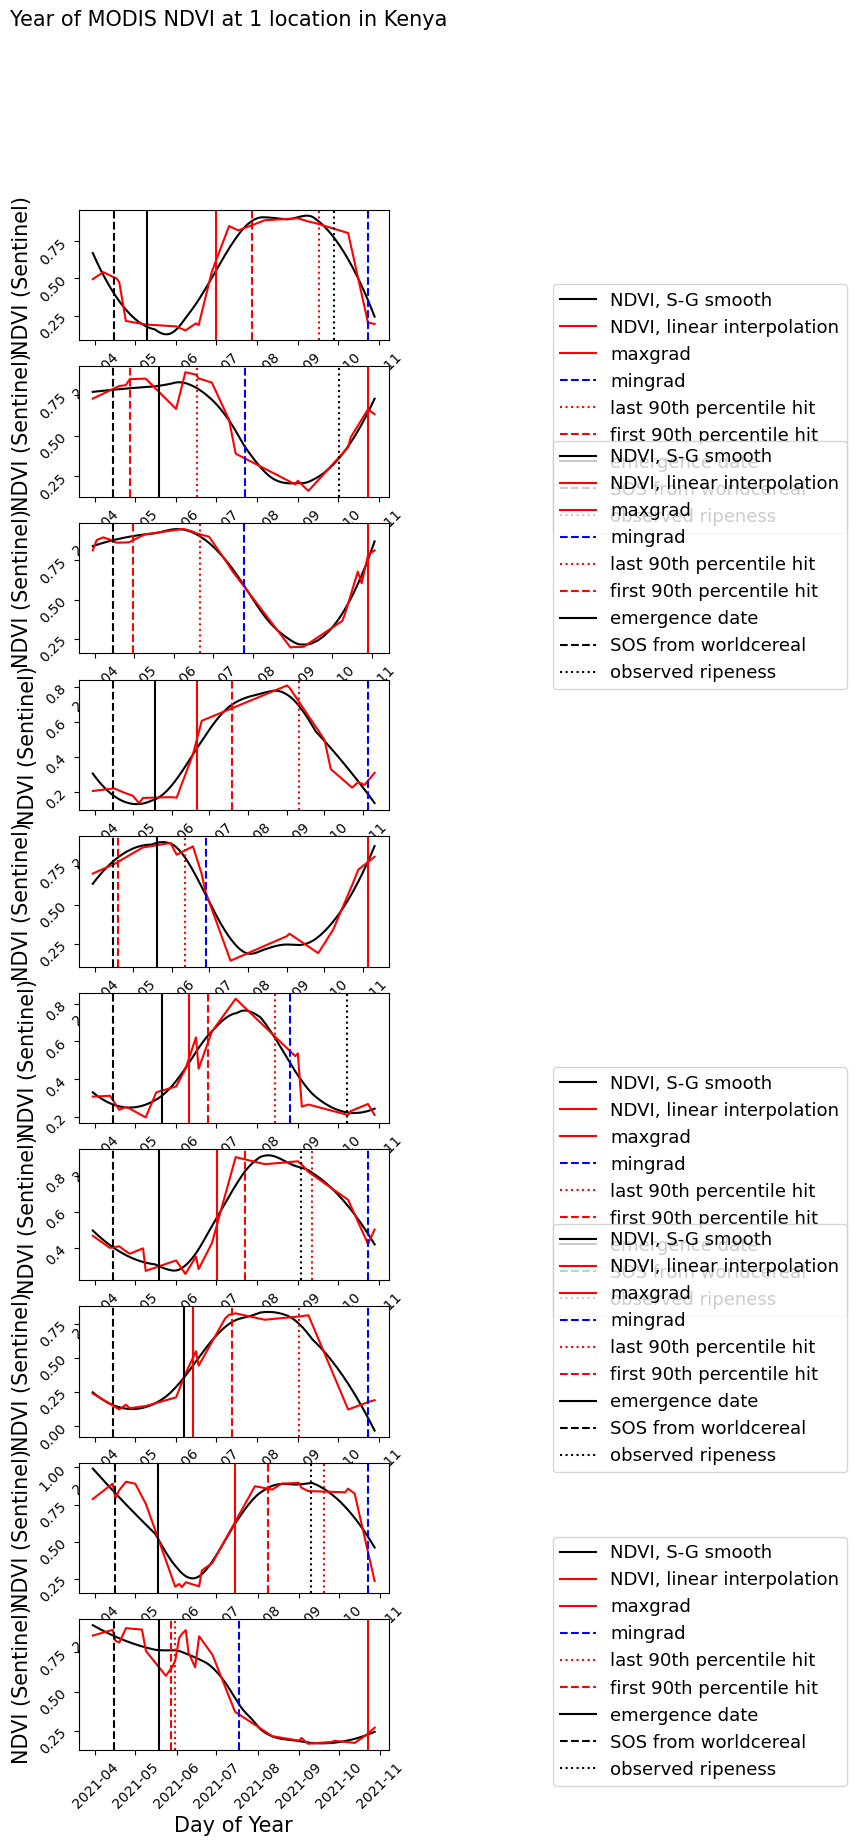

In [29]:
ds_list = []
for start_index in range(0, 25, 25):
    ds_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{start_index}.csv'))
ds = pd.concat(ds_list, axis = 0)
#ds = pd.concat([ds1, ds2, ds3], axis = 0)
ds = ds.where(ds['NDVI'] != -9999).dropna()
ds = ds.where(ds['reducer'] == 'median').dropna()
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2021, font_size = 15, curve='spline', window_length=95)

In [ ]:
ds1.where(ds1['reducer'] == 'median').dropna().loc[:, ['lat', 'lon']].drop_duplicates()

,lat,lon
781,54.3167,10.0500
3125,54.4333,9.8167
5469,54.4000,8.7667
8585,53.9500,10.6833
12478,54.7167,9.9500


In [ ]:
pd.concat([ds1, ds2, ds3]).loc[:, ['lat', 'lon']].drop_duplicates()
ds.loc[:, ['lat', 'lon']].drop_duplicates()

,lat,lon
0,54.4333,9.8167
188,54.4000,8.7667
408,54.7167,9.9500
465,53.4833,10.6333
892,53.5000,10.4833
1098,54.6167,8.9667
1263,54.6667,9.1333
1655,54.5167,8.6500


In [5]:
ds1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata0.csv')
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata5.csv')
ds3 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata10.csv')

In [ ]:
ds1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata0.csv')
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata5.csv')
ds3 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata10.csv')

In [ ]:
ds.dropna()['Stations_Id'].unique()

array([7521., 7532., 7564., 7616., 7623.])

In [ ]:
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0_KEN.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Kenya\\satdata0.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany5\\satdata0.csv')
ds = ds.rename(columns = {'median ndvi': 'NDVI'}, inplace=False)
ds.loc[:, 'NDVI'] = -ds.loc[:, 'NDVI']
ds['year'] = pd.to_datetime(ds['formatted_time'], format='%Y-%m-%d-%H-%M-%S').dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'])
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, font_size = 15)

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encounte

0 lat    54.4333
lon     9.8167
Name: 0, dtype: float64 2020-06-23 00:00:00
Couldn't interpolate
Couldn't interpolate
Couldn't interpolate
4 lat    54.2333
lon    11.0833
Name: 1810, dtype: float64 2020-10-28 00:00:00
5 lat    54.2500
lon    10.8333
Name: 2190, dtype: float64 2020-06-03 00:00:00
no maturity data
Couldn't interpolate
Couldn't interpolate
8 lat    54.6167
lon     9.8333
Name: 3685, dtype: float64 2020-07-31 00:00:00
9 lat    54.55
lon     9.40
Name: 4058, dtype: float64 2020-08-07 00:00:00
10 lat    54.4167
lon     9.5167
Name: 4430, dtype: float64 2020-08-07 00:00:00
11 lat    53.8167
lon    10.1500
Name: 4793, dtype: float64 2020-07-01 00:00:00
no maturity data
12 lat    53.6167
lon    10.4167
Name: 5159, dtype: float64 2020-06-23 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11184\3218324012.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow 

no maturity data
Couldn't interpolate
Couldn't interpolate
15 lat    54.7333
lon     8.4333
Name: 6587, dtype: float64 2020-07-16 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11184\3218324012.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)


IndexError: single positional indexer is out-of-bounds

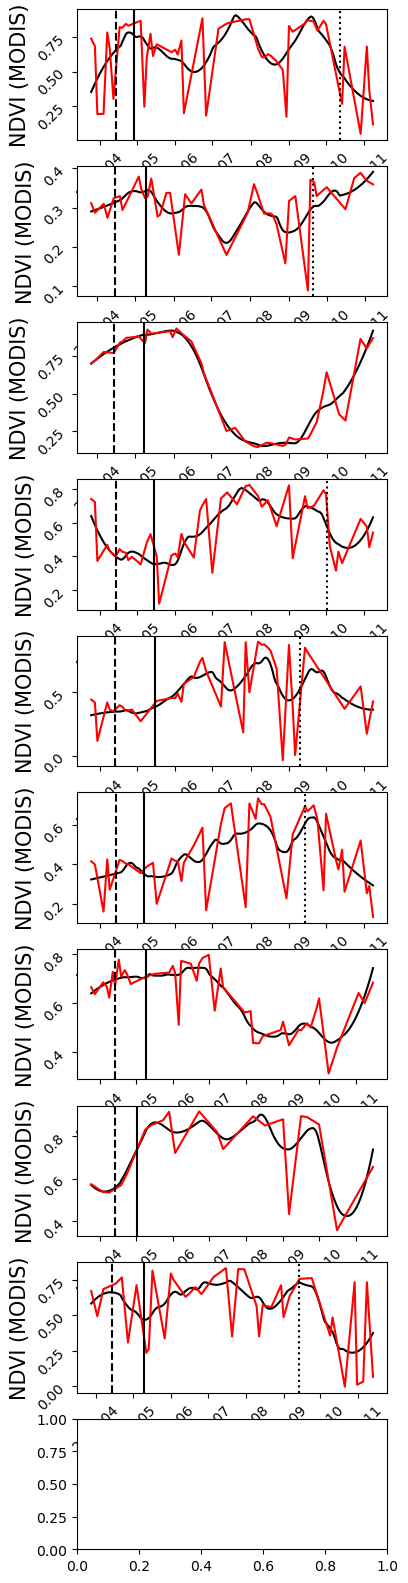

In [ ]:
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0_KEN.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Kenya\\satdata0.csv')#_KEN
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata0.csv')
ds = ds.rename(columns = {'median ndvi': 'NDVI'}, inplace=False)
#ds.loc[:, 'NDVI'] = -ds.loc[:, 'NDVI']
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
ds['year'] = pd.to_datetime(ds['formatted_time'], format='%Y-%m-%d-%H-%M-%S').dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'])
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, font_size = 15)

0 lat    54.4333
lon     9.8167
Name: 0, dtype: float64 2020-06-23 00:00:00
Couldn't interpolate
2 lat    54.7500
lon     9.5167
Name: 758, dtype: float64 2020-06-01 00:00:00
Couldn't interpolate
Couldn't interpolate
5 lat    54.2333
lon    11.0833
Name: 2244, dtype: float64 2020-10-28 00:00:00
6 lat    54.2500
lon    10.8333
Name: 2624, dtype: float64 2020-06-03 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11184\558703886.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: 

7 lat    54.3167
lon    10.2167
Name: 3014, dtype: float64 2020-09-21 00:00:00
Couldn't fit
Couldn't interpolate
Couldn't interpolate
104.0
299.0


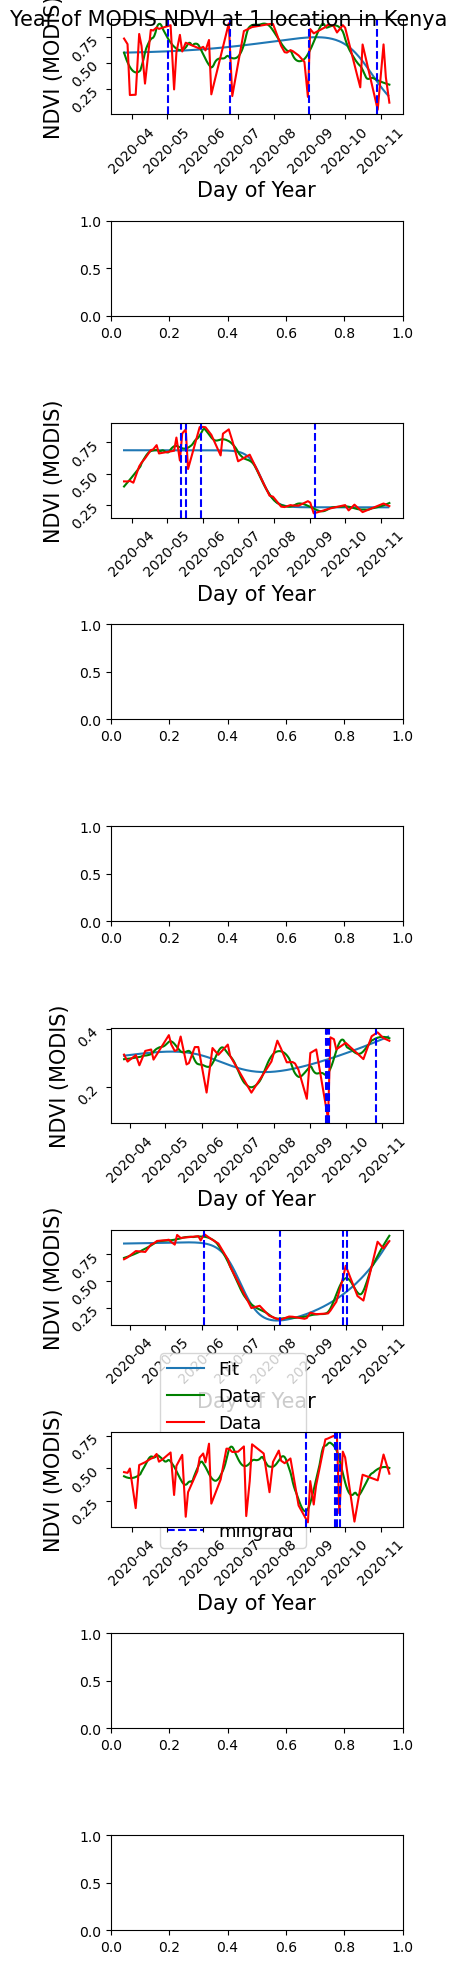

In [ ]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata0.csv')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, shift = 0, font_size = 15)

0 lat    54.3167
lon    10.0500
Name: 0, dtype: float64 2020-09-16 00:00:00
Couldn't fit
1 lat    54.4333
lon     9.8167
Name: 280, dtype: float64 2020-09-16 00:00:00
Couldn't interpolate
3 lat    53.9500
lon    10.6833
Name: 852, dtype: float64 2020-11-07 00:00:00
4 lat    54.7167
lon     9.9500
Name: 1130, dtype: float64 2020-06-26 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


5 lat    54.7500
lon     9.5167
Name: 1413, dtype: float64 2020-05-29 00:00:00
Couldn't fit
Couldn't interpolate
7 lat    53.6167
lon    10.7000
Name: 2240, dtype: float64 2020-07-13 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


8 lat    53.7000
lon    10.7833
Name: 2515, dtype: float64 2020-05-29 00:00:00
Couldn't interpolate


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3520\1639666003.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[location_index - 3].legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))


104.0
300.0


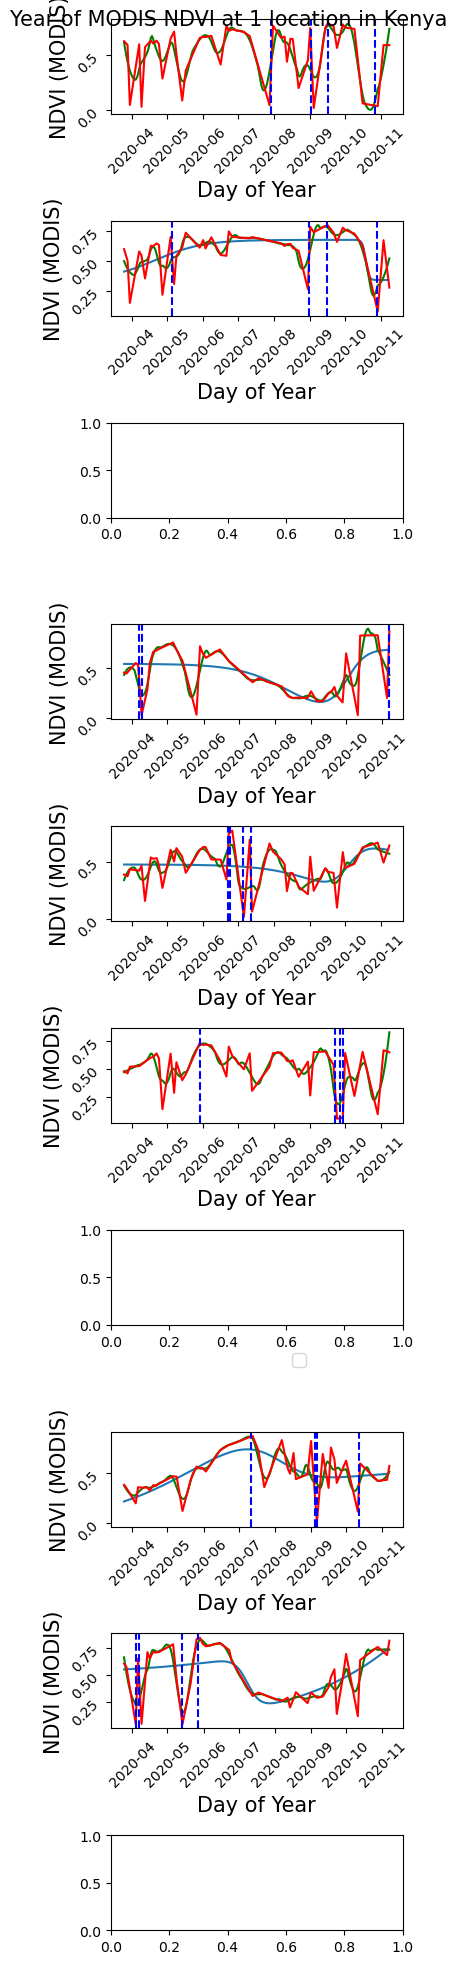

In [ ]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany4\\satdata0.csv')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, shift = 0, font_size = 15)

In [ ]:
pd.DatetimeIndex(max_value_interpolated['time']).min() + Times.astype('timedelta64[D]') #np.timedelta64(Times, 'D')

array([Timestamp('2021-09-23 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-01 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-09 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-17 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-25 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-02 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-10 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-18 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-26 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-04 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-12 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-20 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-02-06 00:00:00+0000', tz=

In [ ]:
def plot_many_NDVI_curves(ds, year, shift = 0, font_size = 15):#LSP_at_stations(ds, start_year, end_year, LSP_method = 'double_logistic', interp_method = 'MVI'):
    results = initialize_LSP_frame(LSP_method)
    print(results)
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
            ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])
            if len(ds_station_year) > 0:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            else:
                print(f'Station {station} in {year} has no observations')
                continue
            if interp_method == 'MVI':
                ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=4) #data_cleaning.
            elif interp_method == 'linear':
                ds_interpolated = data_cleaning.resample_linear(ds_station_year)
            first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
            Times = (pd.DatetimeIndex(ds_interpolated['time']) - pd.DatetimeIndex(ds_interpolated['time']).min()).days.values
            NDVIs = ds_interpolated['NDVI'].values
            try:
                results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station)
            except:
                print(f'Couldn\'t compute LSP for station {station} in year {year}')
                continue
    return results

IndentationError: unexpected indent (106857682.py, line 4)

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168],
      dtype='timedelta64[D]')

In [ ]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#station = ds['Stations_Id'].unique()[0]
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
Times = pd.DatetimeIndex(max_value_interpolated['formatted_time']).dayofyear.values
NDVIs = max_value_interpolated['NDVI'].values

params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


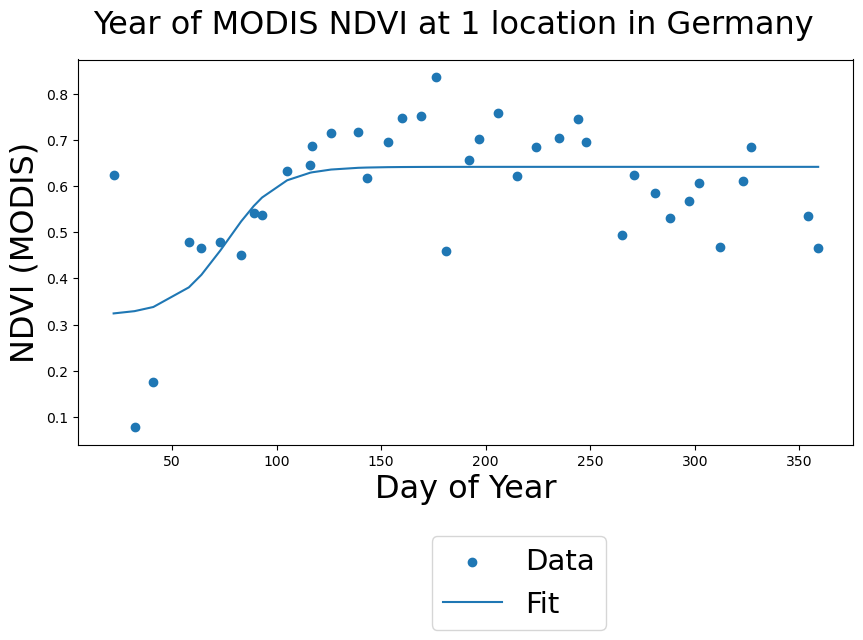

In [ ]:
font_size = 23
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(Times, NDVIs, label = 'Data')
ax.plot(Times, double_logistic(Times/365, *params), label = 'Fit')
ax.set_xlabel('Day of Year', fontsize = font_size)
ax.set_ylabel('NDVI (MODIS)', fontsize = font_size)
fig.suptitle('Year of MODIS NDVI at 1 location in Germany', fontsize = font_size)
ax.legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))

In [ ]:
X = (array_input2['NDVI'] - array_input2['NDVI'].mean(dim='sample')).values
np.corrcoef(X.T)

array([[1.        , 0.83662139, 0.74261934, 0.73125136, 0.70882541],
       [0.83662139, 1.        , 0.80827924, 0.75418058, 0.65950048],
       [0.74261934, 0.80827924, 1.        , 0.76833473, 0.60545472],
       [0.73125136, 0.75418058, 0.76833473, 1.        , 0.71443907],
       [0.70882541, 0.65950048, 0.60545472, 0.71443907, 1.        ]])

In [ ]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
sampled_locs_input2 = make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [ ]:
sampled_locs_input.shape

(95, 20)

In [ ]:
np.mean(sampled_locs_input, axis=0).shape

(20,)

In [ ]:
X = sampled_locs_input - np.mean(sampled_locs_input, axis=0)
Z = sampled_locs_input2 - np.mean(sampled_locs_input2, axis=0)

In [ ]:
X.shape

(95, 20)

In [ ]:
TCA = libtlda.tca.TransferComponentClassifier(kernel_type='sigmoid', num_components = 3)
C, K = TCA.transfer_component_analysis(X, Z)

Adding regularization: 1e-06
Adding regularization: 1e-05
Adding regularization: 0.0001
Adding regularization: 0.001
Adding regularization: 0.01
Adding regularization: 0.1
Adding regularization: 1
Adding regularization: 10
Adding regularization: 100


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\libtlda\tca.py:108: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(np.dot(X, Z.T)))


In [ ]:
adapter = adapt.feature_based.fMMD()
#X_emb.shape
adapter.fit_transform(X, Z)
adapter.transform(np.array([range(20)]))

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.1000e+01  2e+01  1e+00  1e+00
 1:  9.0706e-02 -1.4078e+01  2e+01  7e-01  7e-01
 2:  1.3885e-01 -1.0046e+01  1e+01  5e-01  5e-01
 3:  8.5195e-02 -3.4231e+00  4e+00  4e-12  2e-16
 4:  8.5203e-04 -3.4231e-02  4e-02  7e-14  3e-16
 5:  8.5211e-06 -3.4231e-04  4e-04  8e-14  5e-17
 6:  8.5215e-08 -3.4231e-06  4e-06  5e-13  1e-16
 7:  8.4653e-10 -3.4233e-08  4e-08  9e-13  1e-16
Optimal solution found.


array([[17]])

In [ ]:
adapter.selected_features_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False])

In [ ]:
plt.imshow(np.corrcoef(X.T))

In [ ]:

    #return cross_percentile_date(smoothed_series, 10), cross_percentile_date(smoothed_series, 50), cross_percentile_date(smoothed_series, 90), max_green #Tighter_times[np.int64(smoothed_series.idxmax()*365)]

In [ ]:
fd['time'] = pd.DatetimeIndex(fd['time']).dayofyear
fd = FDataGrid(
    grid_points=fd['time'],
    data_matrix=np.array([fd['NDVI'].values]),
)
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
fd = max_value_interpolated[['NDVI', 'formatted_time']]
fd = fd.rename(columns = {'formatted_time':'time'}).reset_index().drop(['formatted_time', 'level_1'], axis = 1)
os = NadarayaWatsonHatMatrix(bandwidth=60)
fd_os = KernelSmoother(
    kernel_estimator=os,
    output_points=np.arange(10, 350)
)
os_fitted = fd_os.fit_transform(fd)

us = NadarayaWatsonHatMatrix(bandwidth=20)
fd_us = KernelSmoother(
    kernel_estimator=us,
    output_points=np.arange(10, 350)
)
us_fitted = fd_us.fit_transform(fd)
fig, ax = plt.subplots()
ax.plot(fd_os.output_points.squeeze(), os_fitted.data_matrix.squeeze(), color = 'black', linestyle='--')
ax.plot(fd_us.output_points.squeeze(), us_fitted.data_matrix.squeeze(), color = 'black', linestyle=':')
ax.scatter(fd.grid_points, fd.data_matrix.squeeze(), color='red')